# Classifier Diffusion Guidance

With the guided diffusion, we can steer the generation process to improve the quality and diversity of sampling.<br>
First I'll introduce you classifier diffusion guidance.

In the [previous example](./05-class-conditional.ipynb), we have assumed that class labels are known during the training of diffusion models, and fed class label as input in diffusion model.<br>
Using classifier guidance, we take an existing diffusion model (also, unconditional diffusion model) and then steer the generation process at inference time.

With classifier guidance,

- It improves fidelity for image generation, even when used in combination with traditional conditional diffusion models (seen in [previous example](./05-class-conditional.ipynb)).
- Futhermore, you can control a trade-off between fidelity and diversity, such like "temperature" in regular LLMs. (See gradient scale parameter in the following architecture.)
- You can also use guidance, even in unconditional diffusion models.

In this notebook, we assume that the guidance is a class, and we will then build an extra image classifier. But you can also leverage this method into models conditioned on a generic text prompt. (See below note.)

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture & Method

Let's briefly follow theoretical aspects behind Classifier Guidance along with the original paper [[Dhariwal & Nichol, 2021](https://arxiv.org/pdf/2105.05233)].

### 1. Formula of conditioned sampling, $p(\mathbf{x}_t | \mathbf{x}_{t+1}, y)$

Now we suppose the optimal $p(\mathbf{x}_t|\mathbf{x}_{t+1}, y)$ (which is conditional on label $y$) is given, and we then consider how this optimal $p(\mathbf{x}_t|\mathbf{x}_{t+1}, y)$ behaves.

First we assume $\mathbf{x}_0$ has a known label per sample, and $\mathbf{x}_1, \ldots, \mathbf{x}_T$ are noised images, which are seen in [DDPM tutorial](./02-ddpm.ipynb).<br>
As you saw in [DDPM tutorial](./02-ddpm.ipynb), we can suppose $p(\mathbf{x}_{t+1}|\mathbf{x}_t, y) = q(\mathbf{x}_{t+1}|\mathbf{x}_t)$ (not depending on $y$), where $q(\mathbf{x}_{t+1}|\mathbf{x}_t)$ is a forward probability shown in [DDPM tutorial](./02-ddpm.ipynb). (See equation (1) in [DDPM tutorial](./02-ddpm.ipynb).)

Under this assumption, we will get :

$\displaystyle p(\mathbf{x}_{t+1}|\mathbf{x}_t) $

$\displaystyle = \sum_y p(\mathbf{x}_{t+1},y|\mathbf{x}_t) $

$\displaystyle = \sum_y p(\mathbf{x}_{t+1}|\mathbf{x}_t,y) p(y|\mathbf{x}_t) $

$\displaystyle = \sum_y q(\mathbf{x}_{t+1}|\mathbf{x}_t) p(y|\mathbf{x}_t) $

$\displaystyle = q(\mathbf{x}_{t+1}|\mathbf{x}_t) \sum_y p(y|\mathbf{x}_t) $

$\displaystyle = q(\mathbf{x}_{t+1}|\mathbf{x}_t) $

$\displaystyle = p(\mathbf{x}_{t+1}|\mathbf{x}_t, y) $

> Note : I have used $p(\mathbf{x}_{t+1},y|\mathbf{x}_t) = p(\mathbf{x}_{t+1}|\mathbf{x}_t,y)p(y|\mathbf{x}_t)$, because $p(\mathbf{x}_{t+1},y|\mathbf{x}_t) p(\mathbf{x}_t) = p(\mathbf{x}_{t+1}|\mathbf{x}_t,y)p(y|\mathbf{x}_t)p(\mathbf{x}_t)$.

Also, we will have :

$\displaystyle p(y|\mathbf{x}_t, \mathbf{x}_{t+1}) $

$\displaystyle = p(\mathbf{x}_{t+1}|\mathbf{x}_t,y) \frac{p(y|\mathbf{x}_t)}{p(\mathbf{x}_{t+1}|\mathbf{x}_t)}$

$\displaystyle = p(\mathbf{x}_{t+1}|\mathbf{x}_t) \frac{p(y|\mathbf{x}_t)}{p(\mathbf{x}_{t+1}|\mathbf{x}_t)}$

$\displaystyle = p(y|\mathbf{x}_t) \;\;\;\;\;\; (1)$

> Note : Also I have used $p(y|\mathbf{x}_t, \mathbf{x}_{t+1}) p(\mathbf{x}_{t+1}|\mathbf{x}_t) = p(\mathbf{x}_{t+1}|\mathbf{x}_t,y) p(y|\mathbf{x}_t)$, because $p(y|\mathbf{x}_t, \mathbf{x}_{t+1}) p(\mathbf{x}_{t+1}|\mathbf{x}_t) p(\mathbf{x}_t) = p(\mathbf{x}_{t+1}|\mathbf{x}_t,y) p(y|\mathbf{x}_t) p(\mathbf{x}_t)$.

By Bayesian rule and equation (1), we will get :

$\displaystyle p(\mathbf{x}_t | \mathbf{x}_{t+1}, y) $

$\displaystyle = \frac{p(\mathbf{x}_t, \mathbf{x}_{t+1}, y)}{p(\mathbf{x}_{t+1}, y)} $

$\displaystyle = \frac{p(\mathbf{x}_t|\mathbf{x}_{t+1}) p(y|\mathbf{x}_t,\mathbf{x}_{t+1})p(\mathbf{x}_{t+1})}{p(y|\mathbf{x}_{t+1})p(\mathbf{x}_{t+1})} $

$\displaystyle = \frac{p(\mathbf{x}_t|\mathbf{x}_{t+1}) p(y|\mathbf{x}_t,\mathbf{x}_{t+1})}{p(y|\mathbf{x}_{t+1})} $

$\displaystyle = \frac{p(\mathbf{x}_t|\mathbf{x}_{t+1}) p(y|\mathbf{x}_t)}{p(y|\mathbf{x}_{t+1})} $

Because $\frac{1}{p(y|\mathbf{x}_{t+1})}$ doesn't depend on $\mathbf{x}_t$, this result implies that the reverse sampling $p(\mathbf{x}_t | \mathbf{x}_{t+1}, y)$ is given by the following formula when both $\mathbf{x}_{t+1}$ and $y$ are given.

$\displaystyle p(\mathbf{x}_t | \mathbf{x}_{t+1}, y) = Z p_{\theta}(\mathbf{x}_t | \mathbf{x}_{t+1}) p_{\phi}(y | \mathbf{x}_t) \;\;\;\;\;\; (2)$

where $Z$ is a normalizing constant, $\theta$ is parameter for denoising model, and $\phi$ is parameter for the classifier.

> Note : For the proof until here, see Appendix H in the original paper [[Dhariwal & Nichol, 2021](https://arxiv.org/pdf/2105.05233)].

It's worth noting that the classifier $p_{\phi}(y | \mathbf{x}_t)$ will actually be $p_{\phi}(y | \mathbf{x}_t, t)$ (in which $t$ is fed as an input) in the implementation, because $p_{\phi}(y | \mathbf{x}_t)$ predicts $y$ using the noised image $\mathbf{x}_t (t=0,\ldots,T)$.

### 2. Analyze $p_{\theta}(\mathbf{x}_t | \mathbf{x}_{t+1}) p_{\phi}(y | \mathbf{x}_t)$

Now we consider how the right-hand side (RHS) in equation (2) is formulated.

Same as in [DDPM tutorial](./02-ddpm.ipynb), we assume that $p(\mathbf{x}_t | \mathbf{x}_{t+1}, y)$ is also Gaussian as follows. :

$\displaystyle p(\mathbf{x}_t | \mathbf{x}_{t+1}) = \mathcal{N}(\mu, \Sigma) $

The log probability $\log p(\mathbf{x}_t | \mathbf{x}_{t+1}, y)$ is then written by :

$\displaystyle \log p(\mathbf{x}_t | \mathbf{x}_{t+1}) = -\frac{1}{2} (\mathbf{x}_t - \mu)^T \Sigma^{-1} (\mathbf{x}_t - \mu) + C_1 \;\;\;\;\;\; (3)$

where $C_1$ is a constant.

Next, by applying linear approximation at $\mathbf{x}_t = \mu$ in log probability of classification, $\log p(y|\mathbf{x}_t)$, we'll get :

$\displaystyle \log p(y|\mathbf{x}_t) $

$\displaystyle \approx \log p(y|\mathbf{x}_t)|_{\mathbf{x}_t=\mu} + (\mathbf{x}_t - \mu) \nabla_{\mathbf{x}_t} \log p(y|\mathbf{x}_t)|_{\mathbf{x}_t=\mu} $

$\displaystyle = (\mathbf{x}_t - \mu) g + C_2 \;\;\;\;\;\; (4) $

where $g = \nabla_{\mathbf{x}_t} \log p(y|\mathbf{x}_t)|_{\mathbf{x}_t=\mu}$ and $C_2$ is a constant.

By equation (3) and (4), we get :

$\displaystyle \log(p_{\theta}(\mathbf{x}_t | \mathbf{x}_{t+1})p_{\phi}(y|\mathbf{x}_t)) $

$\displaystyle \approx -\frac{1}{2} (\mathbf{x}_t - \mu)^T \Sigma^{-1} (\mathbf{x}_t - \mu) + (\mathbf{x}_t - \mu) g + C_3 $

$\displaystyle = -\frac{1}{2} (\mathbf{x}_t - \mu - \Sigma g)^T \Sigma^{-1} (\mathbf{x}_t - \mu - \Sigma g) + \frac{1}{2} g^T \Sigma g + C_3 $

$\displaystyle = -\frac{1}{2} (\mathbf{x}_t - \mu - \Sigma g)^T \Sigma^{-1} (\mathbf{x}_t - \mu - \Sigma g) + C_4 $

$\displaystyle = \log p(\mathbf{z}) + C_5 $ &nbsp;&nbsp; where $\mathbf{z} \sim \mathcal{N}(\mu + \Sigma g, \Sigma) \;\;\;\;\;\; (5) $

### 3. Algorithm of classifier guidance

As a result, when both diffusion model $\mathcal{N}(\mu_{\theta}(\mathbf{x}_t), \sigma_t^2 \mathbf{I})$ and classifier $p_{\phi}(y|\mathbf{x}_t)$ are given, the sampling algorithm is then :

1. Pick up a white noise $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. For $t = T, \ldots, 1$, loop the following steps
    - $\mu, \Sigma \leftarrow \mu_{\theta}(\mathbf{x}_t), \sigma_t^2 \mathbf{I}$
    - Pick up $\mathbf{x}_{t-1} \sim \mathcal{N}(\mu+s\Sigma\nabla_{\mathbf{x}_t}\log p_{\phi}(y|\mathbf{x}_t),\Sigma)$ where $s$ is a gradient scale (fixed hyper-parameter).
3. Return $\mathbf{x}_0$

> Note : Here I assume that diffusion model is the same one discussed in [DDPM tutorial](./02-ddpm.ipynb) (in which, $\Sigma$ is not learnable).<br>
> When $\Sigma$ is learnable, $\Sigma \leftarrow \Sigma_{\theta}(\mathbf{x}_t)$.

This result intuitively means that **sampling (generating images) to fit to a given class is simply to move the mean to increase probability for the given class during diffusion reserve process**.

As we saw in [DDPM tutorial](./02-ddpm.ipynb), here $\mu_{\theta}$ and $\sigma_t$ are as follows by applying reparameterization.

$\displaystyle \mu_{\theta}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t) \right)$

$\displaystyle \sigma_t^2 = \frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$

### 4. [Optional] Classifier guidance in noise prediction $\epsilon_{\theta}(\mathbf{x}_t)$

As we have seen in ancestral sampling in SDE interpretation, DDPM is interpretable by using score matching as follows. (See (9) in [SDE tutorial](./04-sde.ipynb). Ancestral sampling is a sampling method based on the original DDPM algorithm.)

$\displaystyle \mathbf{x}_{t-1} = \frac{1}{\sqrt{1-\beta_t}}\left(\mathbf{x}_t+\beta_t\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)\right) + \sqrt{\beta_t} \mathbf{z}_t$

> Note : $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$ is replaced with $\mathbf{s}_{\theta^{\ast}}(\mathbf{x}_t, t)$ in score matching.

Because $\mu_{\theta}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t) \right)$, this implies $\frac{1}{\sqrt{1-\beta_t}} \beta_t \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) = -\frac{1}{\sqrt{\alpha_t}} \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t)$ and leads to the following relationship between noise prediction and score matching.

$\displaystyle \epsilon_{\theta}(\mathbf{x}_t) = -\sqrt{1 - \bar{\alpha}_t} \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) $

> Note : It's known that when the noise prediction model $\epsilon_{\theta}(\mathbf{x}_t)$ is well defined, it predicts the scaled score as $\epsilon_{\theta}(\mathbf{x}_t) \approx -\sigma_t \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$.

By substituting this into the conditioned score $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t, y)$, we then get :

$\displaystyle \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t, y) = \nabla_{\mathbf{x}_t} \log(p_{\theta}(\mathbf{x}_t)p_{\phi}(y|\mathbf{x}_t)) $

$\displaystyle \;\; = \nabla_{\mathbf{x}_t} \log p_{\theta}(\mathbf{x}_t) + \nabla_{\mathbf{x}_t} \log p_{\phi}(y|\mathbf{x}_t) $

$\displaystyle \;\; = -\frac{1}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t) + \nabla_{\mathbf{x}_t} \log p_{\phi}(y|\mathbf{x}_t) $

The new $\tilde{\epsilon}_{\theta}(\mathbf{x}_t) \; (= -\sqrt{1 - \bar{\alpha}_t} \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t, y))$ is then obtained by :

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t) = \epsilon_{\theta}(\mathbf{x}_t) - \sqrt{1 - \bar{\alpha}_t} \nabla_{\mathbf{x}_t} \log p_{\phi}(y|\mathbf{x}_t)$

By applying gradient scale $s$, we can get a new $\tilde{\epsilon}_{\theta}(\mathbf{x}_t)$ as follows.

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t) = \epsilon_{\theta}(\mathbf{x}_t) - s \sqrt{1 - \bar{\alpha}_t} \nabla_{\mathbf{x}_t} \log p_{\phi}(y|\mathbf{x}_t) \;\;\;\;\;\; (6)$

Here I don't go so far, but this result can be used in [DDIM](https://arxiv.org/pdf/2010.02502) to speed up sampling (speed up image generation).

### 5. [Optional] Note for practical adoption

Applying classifier guidance with gradient scale $s+1$ to an unconditional diffusion model is then theoretically same as applying classifier guidance with $s$ to a conditional diffusion model, because :

$\displaystyle \epsilon_{\theta}(\mathbf{x}_t) - (s+1) \sigma_t \nabla_{\mathbf{x}_t} \log p_{\phi}(y|\mathbf{x}_t) $

$\displaystyle \approx - \sigma_t \nabla_{\mathbf{x}_t} [\log p(\mathbf{x}_t) + (s+1)\log p_{\phi}(y|\mathbf{x}_t)]$

$\displaystyle = - \sigma_t \nabla_{\mathbf{x}_t} [\log p(\mathbf{x}_t, y) + s\log p_{\phi}(y|\mathbf{x}_t)] $

> Note : See chapter 3.1 in [[Ho & Salimans, 2022](https://arxiv.org/pdf/2207.12598)].

Howevewr, the paper [[Nichol & Dhariwal, 2021](https://arxiv.org/pdf/2102.09672)] says that you can get the best performance by applying classifier guidance to an already class-conditional diffusion model, rather than applying classifier guidance to an unconditional diffusion model.

In this notebook, we'll apply classifier guidance in a pre-trained unconditional diffusion model (which has already been trained in [DDPM tutorial](./02-ddpm.ipynb)) for your learning purpose, but consider to apply classifier guidance to an already class-conditional diffusion model (and set low value as gradient scale $s$) to obtain better performance in practice.

This fact will motivate to classifier-free guidance discussed in the [following tutorial](./07-classifier-free-guidance.ipynb).

## Note: Classifier guidance with a text prompt (Text-to-image)

In this example, we'll build a simple classifier guided model with a class label for your learning purpose.<br>
But you can leverage this architecture into guided models conditioned on a generic text prompt, by using text encoder (such as, [Transformer encoder](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb), etc).

For example, CLIP guidance in [GLIDE](https://arxiv.org/pdf/2112.10741) uses a CLIP model to encode a text sequence.<br>
CLIP consists of two models - an image encoder $f(\mathbf{x})$ and a caption encoder $g(c)$ -, and the similarity between an image $\mathbf{x}$ and a text prompt $c$ is obtained by dot product, $f(\mathbf{x}) \cdot g(c)$.<br>
By applying classifier guidance method, the mean in the conditional reverse-process $\mathcal{N}(\mu_{\theta}(\mathbf{x}_t|c), \Sigma_{\theta}(\mathbf{x}_t|c))$ is then perturbed by the gradient as follows. :

$\displaystyle \tilde{\mu}_{\theta}(\mathbf{x}_t|c) = \mu_{\theta}(\mathbf{x}_t|c) + s \cdot \Sigma_{\theta}(\mathbf{x}_t|c) \nabla_{\mathbf{x}_t}(f(\mathbf{x}) \cdot g(c)) $

> Note : The training of score is performed favorably by using noised images in the paper, but the public CLIP model (which is not trained on noised images) can be used to guide diffusion models.

## Implementation

Now let's see the code (implementation) step-by-step with description of theoretical aspect.

> Note : See [here](https://github.com/openai/guided-diffusion) for official implementation, in which you can experiment with pre-built diffusion models and classifiers trained by ImageNet dataset (which has 1000 classes).

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm

### 1. Build classifier for noised images : $p_{\phi}(y | \mathbf{x}_t, t)$

First we build a classifier $p_{\phi}(y | \mathbf{x}_t, t)$ with CIFAR-10 dataset.

Before building a classifier, we load CIFAR-10 dataset and its dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 256

dataset = datasets.CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Now I show 100 examples.

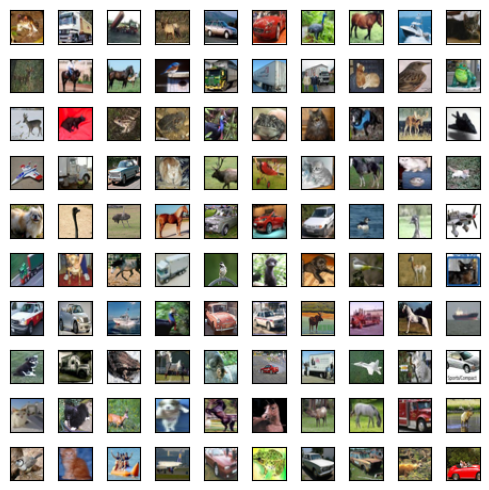

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 10
num_col = 10
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, label in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

In CIFAR10, it just has the following 10 classes.

In [3]:
num_classes = 10
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

I show class name corresponding to each image.

In [4]:
class_names = [classes[l] for l in label.numpy()]
class_names

['frog',
 'truck',
 'truck',
 'deer',
 'automobile',
 'automobile',
 'bird',
 'horse',
 'ship',
 'cat',
 'deer',
 'horse',
 'horse',
 'bird',
 'truck',
 'truck',
 'truck',
 'cat',
 'bird',
 'frog',
 'deer',
 'cat',
 'frog',
 'frog',
 'bird',
 'frog',
 'cat',
 'dog',
 'deer',
 'airplane',
 'airplane',
 'truck',
 'automobile',
 'cat',
 'deer',
 'airplane',
 'cat',
 'horse',
 'cat',
 'cat',
 'dog',
 'bird',
 'bird',
 'horse',
 'automobile',
 'automobile',
 'automobile',
 'bird',
 'bird',
 'airplane',
 'truck',
 'dog',
 'horse',
 'truck',
 'bird',
 'bird',
 'dog',
 'bird',
 'deer',
 'cat',
 'automobile',
 'automobile',
 'ship',
 'bird',
 'automobile',
 'automobile',
 'deer',
 'truck',
 'horse',
 'ship',
 'dog',
 'truck',
 'frog',
 'horse',
 'cat',
 'automobile',
 'truck',
 'airplane',
 'cat',
 'automobile',
 'cat',
 'dog',
 'deer',
 'dog',
 'horse',
 'horse',
 'deer',
 'horse',
 'truck',
 'deer',
 'bird',
 'cat',
 'ship',
 'airplane',
 'automobile',
 'frog',
 'automobile',
 'automobile',
 

Now I build a classifier network.<br>
As we saw above, the noised images are fed into this classifier, and timestep $t$ is also then used to predict classes.

We also apply the same architecture used in [official implementation](https://github.com/openai/guided-diffusion), in which the downsampling trunk of the U-Net model with an attention pool is used.<br>
The final pooling layer (written by "attention pool" in the following flow) is a single layer attention pooling of "transformer-style" multi-head QKV attention where the query is conditioned on the global average-pooled representation of the image (which is used in [CLIP architecture](https://arxiv.org/pdf/2103.00020)).

![Classifier model](./assets/classifier_model.png)

For details about each block implementation in U-Net, see [DDPM tutorial](./02-ddpm.ipynb).

> Note : In order for preventing from name confliction, we temporarily set "```CLS_```" as a prefix in all blocks of this classifier. (This is for tutorial purpose. In production code, the modules will usually be separated between diffusion model and classifier model, and then the name scope won't conflict.)

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# For details about sinusoidal positional encoding in this implementation,
# see https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb
class CLS_PositionalEncoding(nn.Module):
    def __init__(
        self,
        base_dim, # 128
        hidden_dim, # 256
        output_dim, # 512
    ):
        super().__init__()

        # In this example, we assume that the number of embedding dimension is always even.
        # (If not, please pad the result.)
        assert(base_dim % 2 == 0)
        self.timestep_dim = base_dim

        self.hidden1 = nn.Linear(
            base_dim,
            hidden_dim)
        self.hidden2 = nn.Linear(
            hidden_dim,
            output_dim)

    def forward(self, picked_up_timesteps):
        """
        Generate timestep embedding vectors
    
        Parameters
        ----------
        picked_up_timesteps : torch.tensor((batch_size), dtype=int)
            Randomly picked up timesteps
    
        Returns
        ----------
        out : torch.tensor((batch_size, output_dim), dtype=float)
            Generated timestep embeddings (vectors) for each timesteps.
        """

        # Generate 1 / 10000^{2i / d_e}
        # shape : (timestep_dim / 2, )
        interval = 1.0 / (10000**(torch.arange(0, self.timestep_dim, 2.0).to(device) / self.timestep_dim))
        # Generate t / 10000^{2i / d_e}
        # shape : (batch_size, timestep_dim / 2)
        position = picked_up_timesteps.type(torch.get_default_dtype())
        radian = position[:, None] * interval[None, :]
        # Get sin(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        sin = torch.sin(radian).unsqueeze(dim=-1)
        # Get cos(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        cos = torch.cos(radian).unsqueeze(dim=-1)
        # Get sinusoidal positional encoding
        # shape : (batch_size, timestep_dim)
        pe_tmp = torch.concat((sin, cos), dim=-1)   # shape : (num_timestep, timestep_dim / 2, 2)
        d = pe_tmp.size()[1]
        pe = pe_tmp.view(-1, d * 2)                 # shape : (num_timestep, timestep_dim)
        # Apply feedforward
        # shape : (batch_size, timestep_dim * 4)
        out = self.hidden1(pe)
        out = F.silu(out)
        out = self.hidden2(out)

        return out

In [7]:
# Multi-Head Attention operation :
# q, k, v should be channel-last format - such as, (N, H*W, C).
def mha_operation(q, k, v, num_heads):
    # get size and check
    channel = q.size()[-1]
    assert channel % num_heads == 0
    dim_heads = channel // num_heads

    q_len = q.size()[1]
    k_len = k.size()[1]
    v_len = v.size()[1]
    assert k_len == v_len

    # divide into multiple heads :
    #   --> (batch_size, length, num_heads, channel/num_heads)
    q_h = q.view(-1, q_len, num_heads, dim_heads)
    k_h = k.view(-1, k_len, num_heads, dim_heads)
    v_h = v.view(-1, v_len, num_heads, dim_heads)

    # compute Q K^T
    #   --> (batch_size, q_len, k_len, num_heads)
    score = torch.einsum("bihc,bjhc->bijh", q_h, k_h)

    # scale the result by 1/sqrt(channel)
    #   --> (batch_size, q_len, k_len, num_heads)
    score = score / channel**0.5

    # apply softtmax
    #   --> (batch_size, q_len, k_len, num_heads)
    score = F.softmax(score, dim=2)

    # apply dot product with values
    #   --> (batch_size, q_len, num_heads, channel/num_heads)
    out = torch.einsum("bijh,bjhc->bihc", score, v_h)

    # concatenate all heads (without heads)
    #   --> (batch_size, q_len, channel)
    out = out.reshape(-1, q_len, channel)

    return out

In [8]:
class CLS_ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
        down=False,
    ):
        super().__init__()

        self.down = down

        # for normalization
        self.norm1 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=in_channel,
        )
        self.norm2 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=out_channel,
        )

        # for applying conv
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        # to make first conv layer much contribute initially
        # (see https://arxiv.org/pdf/1901.09321)
        for p in self.conv2.parameters():
            p.detach().zero_()

        # for adding timestep
        self.linear_pos = nn.Linear(timestep_embedding_dim, out_channel)

        # for residual block
        if in_channel != out_channel:
            self.linear_src = nn.Linear(in_channel, out_channel)
        else:
            self.linear_src = None

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """

        # apply group norm
        out = self.norm1(x)
        out = F.silu(out)

        # transform in each cases
        # (x_trans is used in last residual layer.)
        if self.down:
            out = F.avg_pool2d(out, (2, 2))
            x_trans = F.avg_pool2d(x, (2, 2))
        else:
            x_trans = x

        # apply conv
        out = self.conv1(out)

        # timestep projection
        pos = F.silu(t_emb)
        pos = self.linear_pos(pos)
        pos = pos[:, :, None, None]
        out = out + pos

        # apply dropout + conv
        out = self.norm2(out)
        out = F.silu(out)
        ##### out = F.dropout(out, p=0.1, training=self.training)
        out = self.conv2(out)

        # apply residual
        if self.linear_src is not None:
            x_trans = x_trans.permute(0, 2, 3, 1) # (N,C,H,W) --> (N,H,W,C)
            x_trans = self.linear_src(x_trans)
            x_trans = x_trans.permute(0, 3, 1, 2) # (N,H,W,C) --> (N,C,H,W)
        out = out + x_trans

        return out

class CLS_AttentionBlock(nn.Module):
    def __init__(
        self,
        channel,
        num_heads,
        num_norm_groups, # 32
    ):
        super().__init__()

        self.num_heads = num_heads

        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=channel,
        )

        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

        self.output_linear = nn.Linear(channel, channel, bias=False)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        out = self.norm(x)

        # reshape : (N,C,H,W) --> (N,H*W,C)
        out = out.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # generate query/key/value
        q = self.q_layer(out)
        k = self.k_layer(out)
        v = self.v_layer(out)

        # apply multi-head attention
        out = mha_operation(q, k, v, num_heads=self.num_heads)

        # apply final linear
        out = self.output_linear(out)

        # reshape : (N,H*W,C) --> (N,C,H,W)
        out = out.view(-1, height, width, channel)
        out = out.permute(0, 3, 1, 2)

        # apply residual
        out = out + x

        return out

class CLS_ResnetAndAttention(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_heads,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
    ):
        super().__init__()

        self.resnet = CLS_ResnetBlock(
            in_channel,
            out_channel,
            num_norm_groups,
            timestep_embedding_dim,
        )
        self.attention = CLS_AttentionBlock(
            out_channel,
            num_heads,
            num_norm_groups,
        )

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """
        out = self.resnet(x, t_emb)
        out = self.attention(out)
        return out

# Used in final pooling, as mentioned above.
# (See https://github.com/openai/CLIP/blob/main/clip/model.py)
class CLS_AttentionPool2d(nn.Module):
    def __init__(
        self,
        in_resolution, # tuple (height, width)
        channel,
        num_heads,
    ):
        super().__init__()

        self.height = in_resolution[0]
        self.width = in_resolution[1]
        self.num_heads = num_heads

        self.pos_embedding = nn.Parameter(
            torch.randn(self.height*self.width + 1, channel) / channel ** 0.5
        )
        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        # reshape
        #   --> (batch_size, height*width, channel)
        out = x.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # apply QKV projection
        mean = torch.mean(out, dim=1, keepdim=True)  # (batch_size, 1, channel)
        out = torch.cat([mean, out], dim=1)          # (batch_size, height*width+1, channel)
        out = out + self.pos_embedding[None,:,:]     # (batch_size, height*width+1, channel)
        q = self.q_layer(out[:,:1,:])                # (batch_size, 1, channel)
        k = self.k_layer(out)                        # (batch_size, height*width+1, channel)
        v = self.v_layer(out)                        # (batch_size, height*width+1, channel)

        # apply multi-head attention
        #   --> (batch_size, 1, channel)
        out = mha_operation(q, k, v, num_heads=self.num_heads)

        #   --> (batch_size, channel)
        return out.squeeze(dim=1)

In [9]:
class CLS_Classifier(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
        head_dim, # 64
    ):
        super().__init__()

        #
        # For timestep embedding
        #
        self.pos_enc = CLS_PositionalEncoding(
            base_dim=unet_base_channel,
            hidden_dim=unet_base_channel*4,
            output_dim=unet_base_channel*4,
        )

        #
        # For U-Net style downsampling
        # (see 02-ddpm.ipynb)
        #
        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            CLS_ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetBlock(        # downsampling
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
                down=True,
            ),
            # 2nd layer
            CLS_ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_heads=(unet_base_channel*2)//head_dim,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_heads=(unet_base_channel*2)//head_dim,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetBlock(        # downsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
                down=True,
            ),
            # 3rd layer
            CLS_ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_heads=(unet_base_channel*2)//head_dim,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_heads=(unet_base_channel*2)//head_dim,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetBlock(        # downsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
                down=True,
            ),
            # 4th layer
            CLS_ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            CLS_ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            CLS_AttentionBlock(
                channel=unet_base_channel*2,
                num_heads=(unet_base_channel*2)//head_dim,
                num_norm_groups=num_norm_groups,
            ),
            CLS_ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])

        #
        # For classification head
        #
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel*2,
        )
        self.pool2d = CLS_AttentionPool2d(
            in_resolution=(4,4),
            channel=unet_base_channel*2,
            num_heads=(unet_base_channel*2)//head_dim,
        )
        self.classify = nn.Linear(unet_base_channel*2, num_classes)

    def forward(self, x, t):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=int)
            timestep
        """

        # generate time embedding
        time_embs = self.pos_enc(t)

        # apply U-Net style top-to-down
        out = self.down_conv(x)
        for block in self.top_to_down:
            out = block(out, time_embs)
        for block in self.middle:
            if isinstance(block, CLS_ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, CLS_AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        # apply classification head
        out = self.norm(out)
        out = F.silu(out)
        out = self.pool2d(out)
        out = self.classify(out)

        return out

In [10]:
#
# Generate classifier
#
classifier = CLS_Classifier(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
    head_dim=64,
).to(device)

Now we train this classifier model.

In this training, we generate noised images and use for training the classifier. For details about this noising process (forward process), see [DDPM tutorial](./02-ddpm.ipynb).

Unlike standard classifier trained on clean images, it needs difficult training on noised images (which has 1000 levels of noises, i.e., $T=1000$), and this extra training will then give a large overhead.

> Note : In this example, I have stopped the training with 500 epochs, but it will need more in practice.<br>
> The training requires all day to complete with a single GPU.

In [11]:
import os

# initialize optimizer
opt = torch.optim.AdamW(classifier.parameters(), lr=3e-4, weight_decay=0.05)

# 1. Initialize T and alpha
#   (See above note for precision.)
T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float64).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# loop
num_epochs = 480
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, label) in enumerate(loader):
        classifier.train()
        opt.zero_grad()

        # 2. Pick up x_0, y
        x_0 = data.to(device)  # shape: (batch_size, 3, 32, 32)
        y = label.to(device)   # shape: (batch_size)

        # 3. Pick up random timestep, t
        b = x_0.size(dim=0)
        t = torch.randint(T, (b,)).to(device)

        # 4. Generate the seed of noise, i.e., epsilon
        eps = torch.randn_like(x_0).to(device)

        # 5. Compute x_t = sqrt(alpha_bar_t) x_0 + sqrt(1-alpha_bar_t) epsilon
        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps

        # 6. Get loss and apply gradient (update)
        logits = classifier(x_t, t)
        loss = F.cross_entropy(logits, y, reduction="mean")
        loss.backward()
        opt.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(classifier.state_dict(), f"06classifier_{epoch_idx}.pt")

print("Done")

epoch1 (iter196) - loss 2.2185
epoch2 (iter196) - loss 2.0959
epoch3 (iter196) - loss 2.0692
epoch4 (iter196) - loss 2.0425
epoch5 (iter196) - loss 2.0166
epoch6 (iter196) - loss 2.0033
epoch7 (iter196) - loss 1.9869
epoch8 (iter196) - loss 1.9765
epoch9 (iter196) - loss 1.9634
epoch10 (iter196) - loss 1.9578
epoch11 (iter196) - loss 1.9506
epoch12 (iter196) - loss 1.9345
epoch13 (iter196) - loss 1.9370
epoch14 (iter196) - loss 1.9264
epoch15 (iter196) - loss 1.9235
epoch16 (iter196) - loss 1.9216
epoch17 (iter196) - loss 1.9152
epoch18 (iter196) - loss 1.9098
epoch19 (iter196) - loss 1.9037
epoch20 (iter196) - loss 1.9038
epoch21 (iter196) - loss 1.8967
epoch22 (iter196) - loss 1.8911
epoch23 (iter196) - loss 1.8907
epoch24 (iter196) - loss 1.8908
epoch25 (iter196) - loss 1.8799
epoch26 (iter196) - loss 1.8770
epoch27 (iter196) - loss 1.8761
epoch28 (iter196) - loss 1.8732
epoch29 (iter196) - loss 1.8735
epoch30 (iter196) - loss 1.8627
epoch31 (iter196) - loss 1.8626
epoch32 (iter196)

Show loss transition in training.

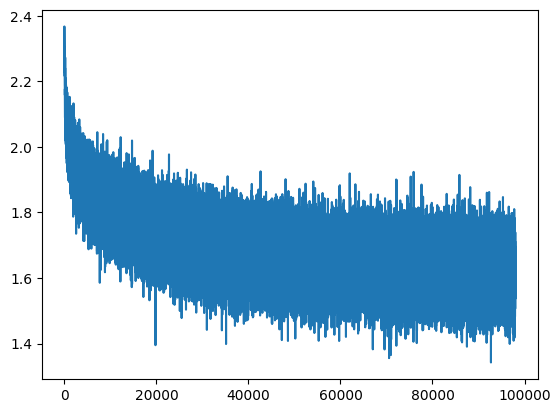

In [12]:
with open(log_file, "r") as f:
    all_loss = [float(line) for line in f]
plt.plot(all_loss)

### 2. Load diffusion model

Next we need a pre-trained diffusion model.

In this example, we use an unconditional diffusion model trained on [DDPM tutorial](./02-ddpm.ipynb).<br>
The following code, therefore, is the same as [DDPM tutorial](./02-ddpm.ipynb).

If you don't have a pre-trained checkpoint (```ddpm_unet_499.pt```), you can also download from [here](https://1drv.ms/u/c/9c0af81b735e29ea/EaPa9ZjhrehLkr23HOVDhAEBFzV0MJ6JFffBMbsAtbHd6A?e=hKG3R6).

In [13]:
##########
# Copy from DDPM tutorial (see 02-ddpm.ipynb)
##########
class PositionalEncoding(nn.Module):
    def __init__(
        self,
        base_dim, # 128
        hidden_dim, # 256
        output_dim, # 512
    ):
        super().__init__()

        # In this example, we assume that the number of embedding dimension is always even.
        # (If not, please pad the result.)
        assert(base_dim % 2 == 0)
        self.timestep_dim = base_dim

        self.hidden1 = nn.Linear(
            base_dim,
            hidden_dim)
        self.hidden2 = nn.Linear(
            hidden_dim,
            output_dim)

    def forward(self, picked_up_timesteps):
        """
        Generate timestep embedding vectors
    
        Parameters
        ----------
        picked_up_timesteps : torch.tensor((batch_size), dtype=int)
            Randomly picked up timesteps
    
        Returns
        ----------
        out : torch.tensor((batch_size, output_dim), dtype=float)
            Generated timestep embeddings (vectors) for each timesteps.
        """

        # Generate 1 / 10000^{2i / d_e}
        # shape : (timestep_dim / 2, )
        interval = 1.0 / (10000**(torch.arange(0, self.timestep_dim, 2.0).to(device) / self.timestep_dim))
        # Generate t / 10000^{2i / d_e}
        # shape : (batch_size, timestep_dim / 2)
        position = picked_up_timesteps.type(torch.get_default_dtype())
        radian = position[:, None] * interval[None, :]
        # Get sin(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        sin = torch.sin(radian).unsqueeze(dim=-1)
        # Get cos(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        cos = torch.cos(radian).unsqueeze(dim=-1)
        # Get sinusoidal positional encoding
        # shape : (batch_size, timestep_dim)
        pe_tmp = torch.concat((sin, cos), dim=-1)   # shape : (num_timestep, timestep_dim / 2, 2)
        d = pe_tmp.size()[1]
        pe = pe_tmp.view(-1, d * 2)                 # shape : (num_timestep, timestep_dim)
        # Apply feedforward
        # shape : (batch_size, timestep_dim * 4)
        out = self.hidden1(pe)
        out = F.silu(out)
        out = self.hidden2(out)

        return out

In [14]:
##########
# Copy from DDPM tutorial (see 02-ddpm.ipynb)
##########
class ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
    ):
        super().__init__()

        # for normalization
        self.norm1 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=in_channel,
            eps=1e-06,
        )
        self.norm2 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=out_channel,
            eps=1e-06,
        )

        # for applying conv
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

        # for adding timestep
        self.linear_pos = nn.Linear(timestep_embedding_dim, out_channel)

        # for residual block
        if in_channel != out_channel:
            self.linear_src = nn.Linear(in_channel, out_channel)
        else:
            self.linear_src = None

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """

        # Apply conv
        out = self.norm1(x)
        out = F.silu(out)
        out = self.conv1(out)

        # Add timestep encoding
        pos = F.silu(t_emb)
        pos = self.linear_pos(pos)
        pos = pos[:, :, None, None]
        out = out + pos

        # apply dropout + conv
        out = self.norm2(out)
        out = F.silu(out)
        out = F.dropout(out, p=0.1, training=self.training)
        out = self.conv2(out)

        # apply residual
        if self.linear_src is not None:
            x_trans = x.permute(0, 2, 3, 1)       # (N,C,H,W) --> (N,H,W,C)
            x_trans = self.linear_src(x_trans)
            x_trans = x_trans.permute(0, 3, 1, 2) # (N,H,W,C) --> (N,C,H,W)
            out = out + x_trans
        else:
            out = out + x

        return out

#
# For the implementation of multi-head attention,
# see https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb
#
class AttentionBlock(nn.Module):
    def __init__(
        self,
        channel,
        num_norm_groups, # 32
    ):
        super().__init__()

        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=channel,
            eps=1e-06,
        )

        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

        self.output_linear = nn.Linear(channel, channel, bias=False)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        out = self.norm(x)

        # reshape : (N,C,H,W) --> (N,H*W,C)
        out = out.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # generate query/key/value
        q = self.q_layer(out)
        k = self.k_layer(out)
        v = self.v_layer(out)

        # compute Q K^T
        score = torch.einsum("bic,bjc->bij", q, k)

        # scale the result by 1/sqrt(channel)
        score = score / channel**0.5

        # apply softtmax
        score = F.softmax(score, dim=-1)

        # apply dot product with values
        out = torch.einsum("bij,bjc->bic", score, v)

        # apply final linear
        out = self.output_linear(out)

        # reshape : (N,H*W,C) --> (N,C,H,W)
        out = out.view(-1, height, width, channel)
        out = out.permute(0, 3, 1, 2)

        # apply residual
        out = out + x

        return out

class ResnetAndAttention(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
    ):
        super().__init__()

        self.resnet = ResnetBlock(
            in_channel,
            out_channel,
            num_norm_groups,
            timestep_embedding_dim,
        )
        self.attention = AttentionBlock(
            out_channel,
            num_norm_groups,
        )

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """
        out = self.resnet(x, t_emb)
        out = self.attention(out)
        return out

# Resized into the shape (C,H/2,W/2)
# (This is equivalent to torch.nn.Conv2d.)
class DownSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        return self.conv(x)

# Resized into the shape (C,H*2,W*2)
class UpSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode="nearest")
        out = self.conv(out)
        return out

In [15]:
##########
# Copy from DDPM tutorial (see 02-ddpm.ipynb)
##########
class UNet(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
    ):
        super().__init__()

        self.pos_enc = PositionalEncoding(
            base_dim=unet_base_channel,
            hidden_dim=unet_base_channel*2,
            output_dim=unet_base_channel*4,
        )

        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel,
            ),
            # 2nd layer
            ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            AttentionBlock(
                channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.bottom_to_up = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 2nd layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel,
            eps=1e-06,
        )
        self.up_conv = nn.Conv2d(
            unet_base_channel,
            source_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x, t):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=int)
            timestep
        """

        buffer = []

        # generate time embedding
        time_embs = self.pos_enc(t)

        #
        # Top-to-down
        #

        # apply down-convolution
        out = self.down_conv(x)
        buffer.append(out)
        # apply top-to-down
        for block in self.top_to_down:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, ResnetAndAttention):
                out = block(out, time_embs)
            elif isinstance(block, DownSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
            buffer.append(out)

        #
        # Middle
        #
        for block in self.middle:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        #
        # Bottom-to-up
        #

        # apply bottom-to-up
        for block in self.bottom_to_up:
            if isinstance(block, ResnetBlock):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs)
            elif isinstance(block, ResnetAndAttention):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs)
            elif isinstance(block, UpSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
        # apply up-convolution
        out = self.norm(out)
        out = F.silu(out)
        out = self.up_conv(out)

        assert not buffer

        return out

In [16]:
#
# Load a pretrained model
#
unet = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
).to(device)
unet.load_state_dict(torch.load("ddpm_unet_499.pt", weights_only=True))

<All keys matched successfully>

### 3. Generate images with classifier guidance

Now we generate images (sampling) applying classifier guidance.

As I have mentioned above, the sampling algorithm is as follows. :

1. Pick up a white noise $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. For $t = T, \ldots, 1$, loop the following steps
    - $\mu \leftarrow \mu_{\theta}(\mathbf{x}_t, t)$ where $\mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t,t) \right)$.
    - Pick up $\mathbf{x}_{t-1} \sim \mathcal{N}(\mu+s\sigma_t^2\nabla_{\mathbf{x}_t}\log p_{\phi}(y|\mathbf{x}_t),\sigma_t^2 \mathbf{I})$ where $\sigma_t^2 = \frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$ and $s$ is a gradient scale (fixed hyper-parameter).
3. Return $\mathbf{x}_0$

> Note : In generation (sampling) with diffusion guidance, you can also apply DDIM (Denoising Diffusion Implicit Models) to speed up inference.<br>
> See [official repository](https://github.com/openai/guided-diffusion).

In [17]:
import tqdm

def run_inference(unet, classifier, class_name, class_list, gradient_scale, num_row=10, num_col=10):
    unet.eval()
    classifier.eval()

    #####
    # preparation
    #####

    # generate array of sigma_t
    alpha_bars_prev = torch.cat((torch.ones(1).to(device), alpha_bars[:-1]))
    sigma_t_squared = (1.0 - alphas) * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)
    sigma_t = torch.sqrt(sigma_t_squared)

    # generate y (tensor batch array of class id)
    class_id_list = [i for i,v in enumerate(class_list) if v==class_name]
    if len(class_id_list) == 0:
        raise Exception("class name doesn't exist")
    y = class_id_list[0]
    y_batch = (torch.tensor(y).to(device)).repeat(num_row*num_col)

    #####
    # 1. make white noise
    #####
    x = torch.randn(num_row*num_col, 3, 32, 32).to(device)

    #####
    # 2. loop
    #####
    for t in tqdm.tqdm(reversed(range(T)), total=T):
        # get mu
        t_batch = (torch.tensor(t).to(device)).repeat(num_row*num_col)
        with torch.no_grad():
            epsilon = unet(x, t_batch)
        mu = (1.0 / torch.sqrt(alphas[t])).float() * (x - ((1.0 - alphas[t]) / torch.sqrt(1.0 - alpha_bars[t])).float() * epsilon)

        # get nabla_x(log(p(y|x))) at x_t
        x_in = x.detach().requires_grad_(True)
        logits = classifier(x_in, t_batch)
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y_batch.view(-1)]
        grad = torch.autograd.grad(selected.sum(), x_in)[0]

        # pick up x_{t-1}
        if t > 0:
            z = torch.randn_like(x).to(device)
        else:
            z = torch.zeros_like(x).to(device)
        x = mu + gradient_scale * sigma_t_squared[t].float() * grad + \
            sigma_t[t].float() * z

    #####
    # 3. get x_0
    #####

    # reshape to channels-last : (N,C,H,W) --> (N,H,W,C)
    x = x.permute(0, 2, 3, 1)
    # clip
    x = torch.clamp(x, min=0.0, max=1.0)

    #####
    # draw
    #####
    fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(num_row*num_col):
        image = x[i].cpu().numpy()
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image)

100%|████████████████████████████████████████████████████████████| 1000/1000 [07:21<00:00,  2.27it/s]


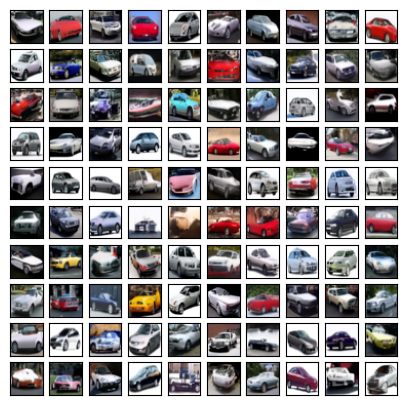

In [18]:
run_inference(
    unet,
    classifier,
    "automobile",
    class_list=classes,
    gradient_scale=10.0
)

100%|████████████████████████████████████████████████████████████| 1000/1000 [07:22<00:00,  2.26it/s]


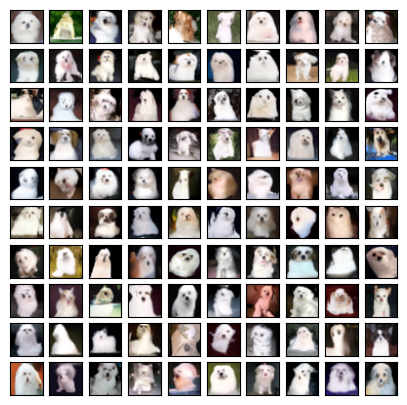

In [19]:
run_inference(
    unet,
    classifier,
    "dog",
    class_list=classes,
    gradient_scale=10.0
)